## Data Preparation

In [5]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import statistics
import math

#for LSTM model
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [6]:
#from google.colab import drive
#drive.mount('/content/drive')

In [7]:
# read data
data = pd.read_csv("HistoricalProductDemand.csv")

In [8]:
# rename the columns
data.rename(columns = {'Product_Code': 'ProductCode',
                       'Product_Category': 'ProductCategory', 
                       'Order_Demand': 'OrderDemand'}, inplace = True)
data.head()

,ProductCode,Warehouse,ProductCategory,Date,OrderDemand
0,Product_0993,Whse_J,Category_028,27-07-2012,100
1,Product_0979,Whse_J,Category_028,19-01-2012,500
2,Product_0979,Whse_J,Category_028,03-02-2012,500
3,Product_0979,Whse_J,Category_028,09-02-2012,500
4,Product_0979,Whse_J,Category_028,02-03-2012,500


In [9]:
# check the null data
data.isnull().sum()

ProductCode            0
Warehouse              0
ProductCategory        0
Date               11239
OrderDemand            0
dtype: int64

In [10]:
# drop the missing values, we can not fill the date so best way drop missing samples
data.dropna(inplace=True)

# check the null data again
data.isnull().sum()

ProductCode        0
Warehouse          0
ProductCategory    0
Date               0
OrderDemand        0
dtype: int64

In [11]:
# sort the data according yo date column
data.sort_values('Date', ignore_index=True, inplace=True)
data.head()

,ProductCode,Warehouse,ProductCategory,Date,OrderDemand
0,Product_2166,Whse_S,Category_024,01-01-2012,2
1,Product_1480,Whse_S,Category_019,01-01-2013,3000
2,Product_2167,Whse_S,Category_024,01-01-2013,20
3,Product_1792,Whse_S,Category_024,01-01-2013,10
4,Product_1645,Whse_S,Category_024,01-01-2013,10


In [12]:
# there are () int the OrderDemand column and we need to remove them
data['OrderDemand'] = data['OrderDemand'].astype(str).str.replace("(","")
data['OrderDemand'] = data['OrderDemand'].astype(str).str.replace(')',"")

# change the dtype as int64
data['OrderDemand'] = data['OrderDemand'].astype('int64')

In [13]:
# creating Year, Month, Day field for further analysis

# first way
# data[["Year", "Month", "Day"]] = data["Date"].str.split("/", expand = True)
# data

# second way change date columns dtype as datetime 
from datetime import datetime as dt

# convert the 'Date' column to datetime format
data['Date']= pd.to_datetime(data['Date'])

# create Year, Month, Day columns
data['Year'] = data["Date"].dt.year
data['Month'] = data["Date"].dt.month
data['Day'] = data["Date"].dt.day
# i used second way because i think it is more usable for dtypes

## Exploratory Data Analysis and Data Visualization

In [14]:
# information about data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1037336 entries, 0 to 1037335
Data columns (total 8 columns):
 #   Column           Non-Null Count    Dtype         
---  ------           --------------    -----         
 0   ProductCode      1037336 non-null  object        
 1   Warehouse        1037336 non-null  object        
 2   ProductCategory  1037336 non-null  object        
 3   Date             1037336 non-null  datetime64[ns]
 4   OrderDemand      1037336 non-null  int64         
 5   Year             1037336 non-null  int64         
 6   Month            1037336 non-null  int64         
 7   Day              1037336 non-null  int64         
dtypes: datetime64[ns](1), int64(4), object(3)
memory usage: 63.3+ MB


In [15]:
# statistical information about OrderDemand
data["OrderDemand"].describe()

count    1.037336e+06
mean     4.920153e+03
std      2.907840e+04
min     -9.990000e+05
25%      1.900000e+01
50%      3.000000e+02
75%      2.000000e+03
max      4.000000e+06
Name: OrderDemand, dtype: float64

In [16]:
# information about categorical variables
data[["ProductCode", "Warehouse", "ProductCategory"]].describe()

,ProductCode,Warehouse,ProductCategory
count,1037336,1037336,1037336
unique,2160,4,33
top,Product_1359,Whse_J,Category_019
freq,16936,764447,470266


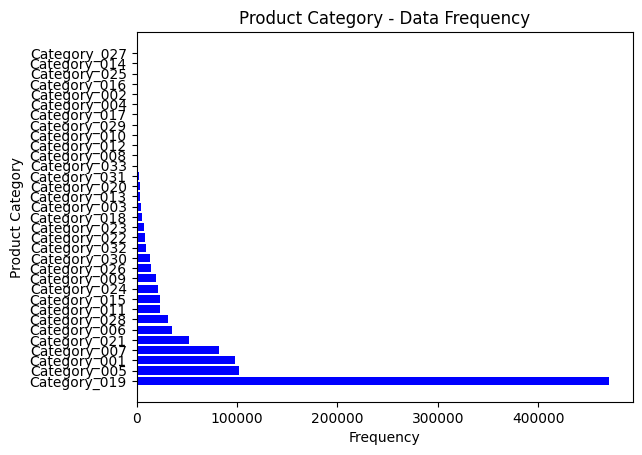

Number of ProductCategory 
Category_019    470266
Category_005    101627
Category_001     97787
Category_007     82402
Category_021     52008
Category_006     35552
Category_028     31012
Category_011     23208
Category_015     22954
Category_024     20885
Category_009     19738
Category_026     14771
Category_030     12997
Category_032      9296
Category_022      8657
Category_023      7899
Category_018      5239
Category_003      4189
Category_013      3743
Category_020      3490
Category_031      2268
Category_033      1849
Category_008      1560
Category_012      1147
Category_010       976
Category_029       671
Category_017       615
Category_004       329
Category_002        77
Category_016        37
Category_025        35
Category_014        26
Category_027        26
Name: ProductCategory, dtype: int64


In [17]:
# Number of samples according to ProductCategory
plt.figure()
plt.barh(data["ProductCategory"].value_counts().index, data["ProductCategory"].value_counts(), color = "b")
plt.xlabel("Frequency")
plt.ylabel("Product Category")
plt.title("Product Category - Data Frequency")
plt.show()
print(f"Number of ProductCategory \n{data['ProductCategory'].value_counts()}")

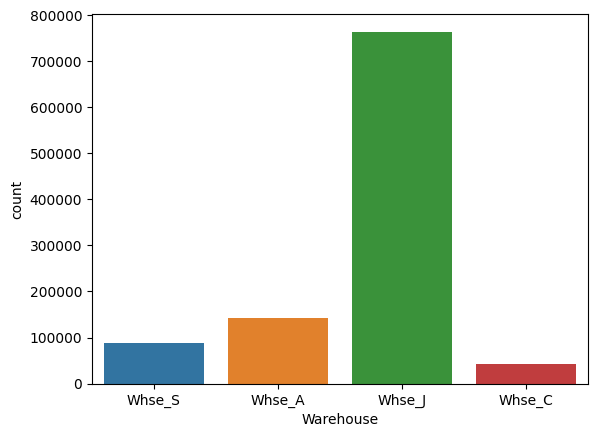

Number of samples according to Warehouse 
Whse_J    764447
Whse_A    142335
Whse_S     88200
Whse_C     42354
Name: Warehouse, dtype: int64


In [18]:
# Number of samples according to Warehouse
sns.countplot(x="Warehouse", data=data)
plt.xticks(rotation = 0)
plt.show()
print(f"Number of samples according to Warehouse \n{data['Warehouse'].value_counts()}")

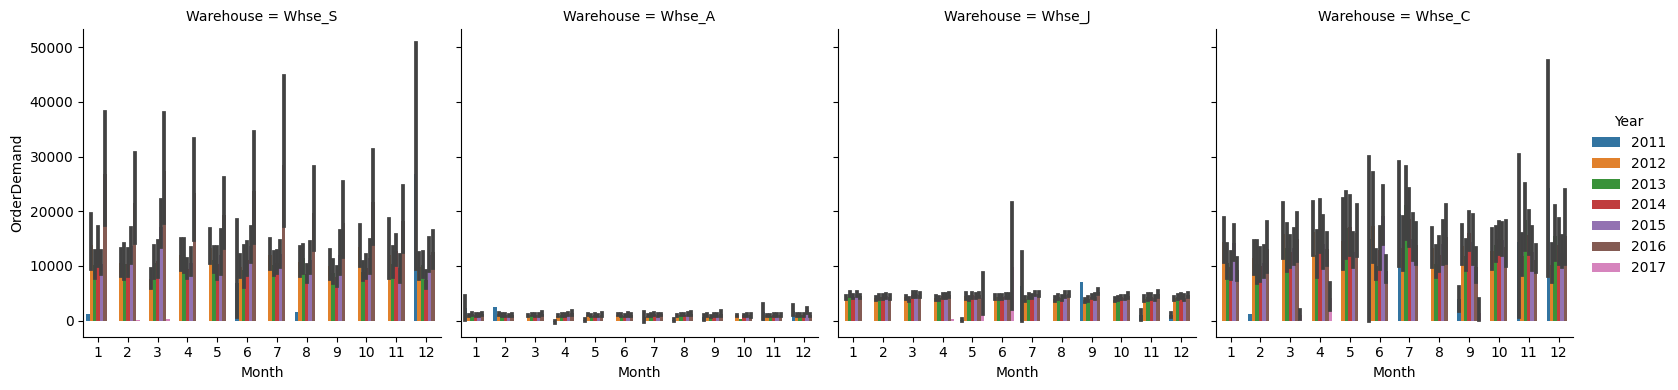

In [19]:
sns.catplot(x="Month", y="OrderDemand",  hue="Year", col="Warehouse",
            data=data, kind="bar", height=4)
plt.show()

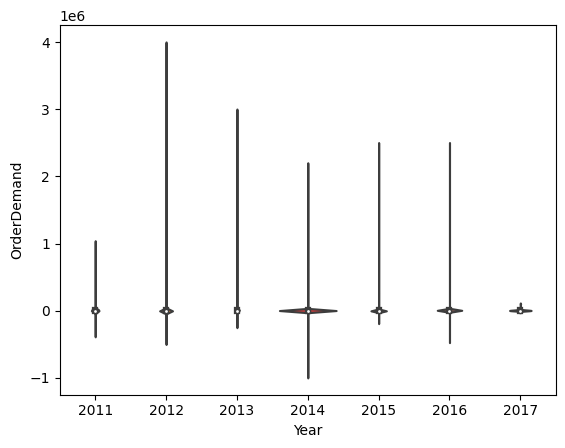

In [20]:
sns.violinplot(x="Year", y="OrderDemand", data=data)
plt.show()

#### Yearly Analysis

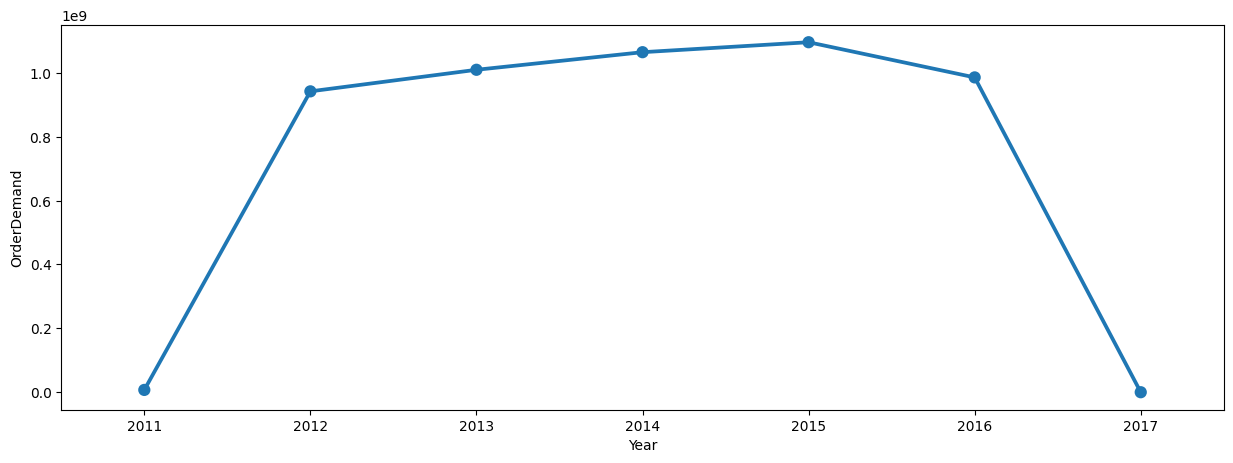

In [21]:
df = data[['OrderDemand', 'Year']].groupby(["Year"]).sum().reset_index().sort_values(by='Year', ascending=False)
f, ax=plt.subplots(figsize=(15, 5))
sns.pointplot(x='Year', y='OrderDemand', data=df)
plt.show()

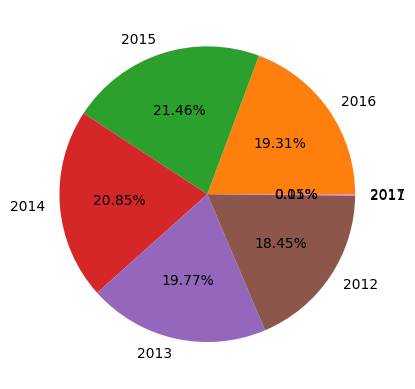

In [22]:
# plot a pie chart and see percentages of Order Demand according to the years
plt.pie(df['OrderDemand'], labels=df['Year'].unique(), autopct='%1.2f%%')
plt.show() 

#### Monthly Analysis

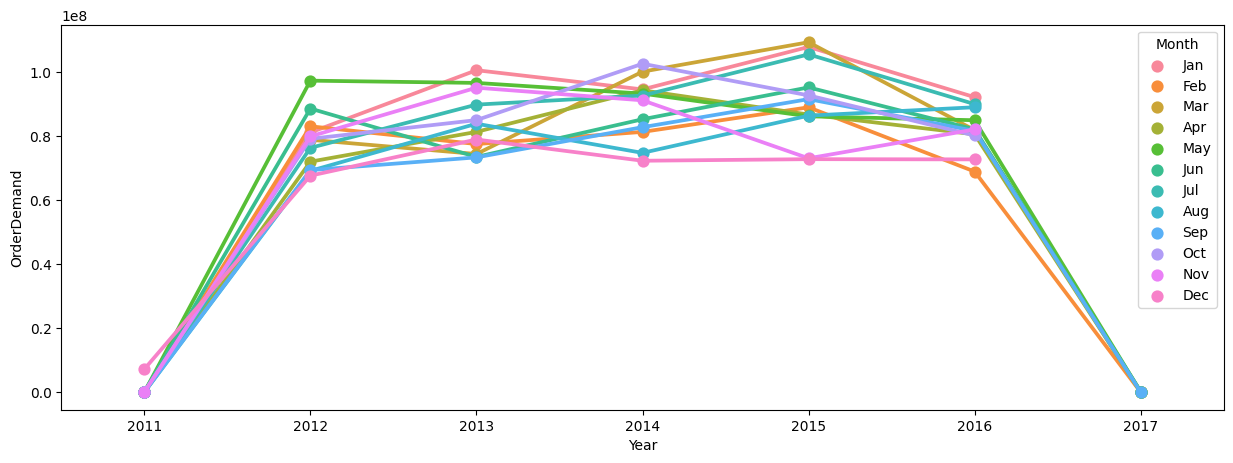

In [23]:
temp_data = data.copy()
temp_data.Month.replace([1,2,3,4,5,6,7,8,9,10,11,12], ['Jan', 'Feb', 'Mar', 'Apr', 'May',
                                                       'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], inplace=True)
df = temp_data[['OrderDemand',
                'Month', 'Year',]].groupby(["Year",
                                            "Month"]).sum().reset_index().sort_values(by=['Year',
                                                                                          'Month'], ascending=False)
f, ax=plt.subplots(figsize=(15, 5))
sns.pointplot(x='Year', y='OrderDemand', data=df, hue='Month', hue_order=['Jan', 'Feb', 'Mar', 'Apr', 'May',
                                                                          'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.show()

In [24]:
# Monthly pivot table
df = (df.pivot(index='Year', columns='Month', values='OrderDemand'))
df = df.loc[:, ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']]
df

Month,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
Year,,,,,,,,,,,,
2011,5750.0,3750.0,NaN,-500.0,661.0,132079.0,54501.0,1805.0,32649.0,-1.0,85702.0,7193590.0
2012,81058086.0,82995376.0,78780374.0,71955994.0,97238354.0,88530790.0,76267860.0,69079780.0,69314308.0,79087899.0,79846728.0,67587358.0
2013,100499271.0,77454566.0,74344191.0,81255882.0,96534553.0,73434208.0,89758807.0,83799681.0,73295422.0,84927451.0,95045236.0,78869530.0
2014,94505401.0,81243599.0,100046038.0,94226084.0,93194053.0,85190884.0,92591770.0,74697568.0,82717528.0,102515926.0,91100218.0,72243410.0
2015,107761608.0,88921986.0,109233109.0,86663541.0,86104194.0,95139572.0,105443242.0,86318138.0,91475419.0,92638946.0,73008770.0,72736440.0
2016,92080638.0,68860355.0,81789118.0,80488756.0,84885847.0,82041160.0,89909788.0,88942446.0,81566973.0,80126387.0,82009580.0,72667081.0
2017,NaN,70.0,2400.0,29250.0,83929.0,175140.0,NaN,NaN,4178.0,NaN,NaN,NaN


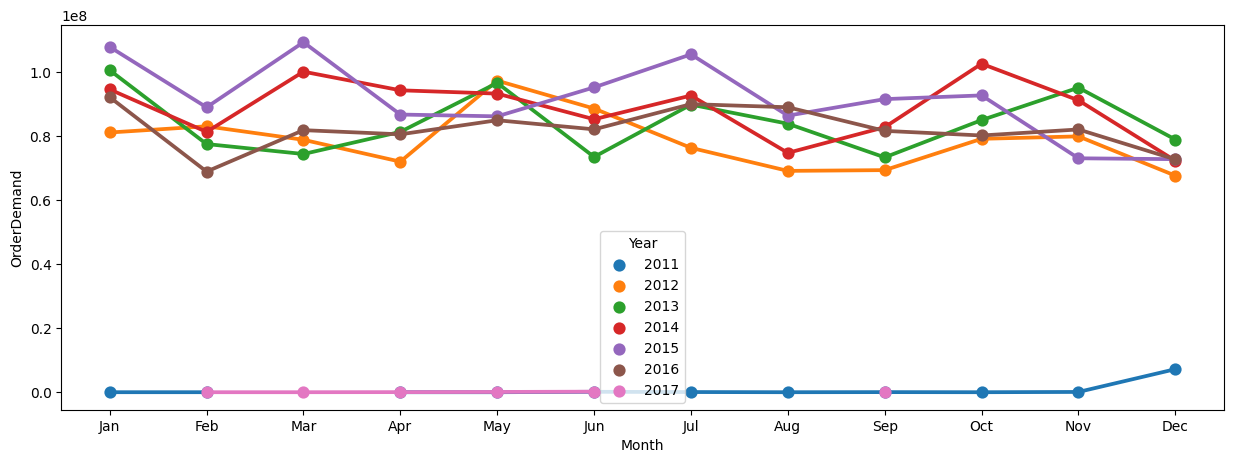

In [25]:
custom_dict = {'Jan':0, 'Feb':1, 'Mar':2, 'Apr':3, 'May':4, 'Jun':5,
               'Jul':6, 'Aug':7, 'Sep':8, 'Oct':9, 'Nov':10, 'Dec':11}
temp_data = data.copy()
temp_data.Month.replace([1,2,3,4,5,6,7,8,9,10,11,12], ['Jan', 'Feb', 'Mar', 'Apr', 'May', 
                                                               'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], inplace=True)
df = temp_data[["OrderDemand", 'Month', 'Year']].groupby(["Year",
                                                  "Month"]).sum().reset_index().sort_values(by=['Year', 
                                                                                                 'Month'], ascending=True)
df = df.iloc[df['Month'].map(custom_dict).argsort()]
f, ax=plt.subplots(figsize=(15, 5))
sns.pointplot(x='Month', y="OrderDemand", data=df, hue="Year")
plt.show()

In [26]:
# Statistical information about monthly data
df.describe()

,Year,OrderDemand
count,77.000000,7.700000e+01
mean,2013.805195,6.628380e+07
std,1.885115,3.639805e+07
min,2011.000000,-5.000000e+02
25%,2012.000000,6.907978e+07
50%,2014.000000,8.105809e+07
75%,2015.000000,8.975881e+07
max,2017.000000,1.092331e+08


#### Warehouse Based Analysis

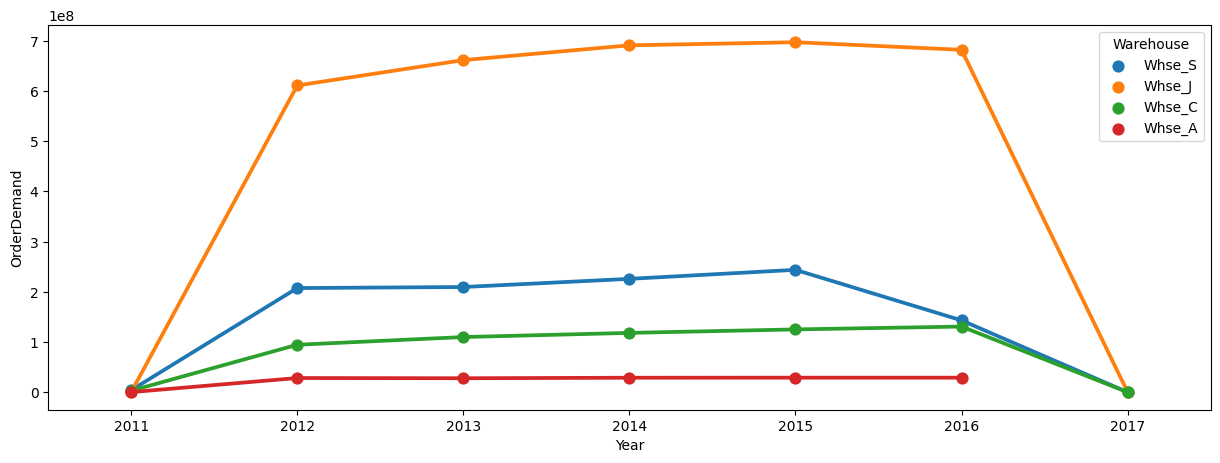

In [27]:
df = data[["OrderDemand", 'Year', 'Warehouse']].groupby(["Year",
                                                         "Warehouse"]).sum().reset_index().sort_values(by=['Warehouse','Year'], ascending=False)
f, ax=plt.subplots(figsize=(15, 5))
sns.pointplot(x='Year', y="OrderDemand", data=df, hue="Warehouse")
plt.show()

In [28]:
df = (df.pivot(index='Year', columns='Warehouse', values='OrderDemand'))
df

Warehouse,Whse_A,Whse_C,Whse_J,Whse_S
Year,,,,
2011,219669.0,3031847.0,196137.0,4062333.0
2012,28298540.0,94596073.0,611270559.0,207577735.0
2013,27866100.0,109938491.0,661775416.0,209638791.0
2014,28879054.0,118245964.0,691259773.0,225887688.0
2015,28995542.0,125149312.0,697430144.0,243869967.0
2016,28998778.0,130848147.0,682330370.0,143190834.0
2017,NaN,35378.0,259319.0,270.0


In [29]:
# Statistical information about according to warehouse data
df.describe()

Warehouse,Whse_A,Whse_C,Whse_J,Whse_S
count,6.000000e+00,7.000000e+00,7.000000e+00,7.000000e+00
mean,2.387628e+07,8.312074e+07,4.777888e+08,1.477468e+08
std,1.159815e+07,5.693032e+07,3.274770e+08,1.042841e+08
min,2.196690e+05,3.537800e+04,1.961370e+05,2.700000e+02
25%,2.797421e+07,4.881396e+07,3.057649e+08,7.362658e+07
50%,2.858880e+07,1.099385e+08,6.617754e+08,2.075777e+08
75%,2.896642e+07,1.216976e+08,6.867951e+08,2.177632e+08
max,2.899878e+07,1.308481e+08,6.974301e+08,2.438700e+08


#### Product Category Based Analysis

In [30]:
df = data[["OrderDemand",
           'ProductCategory', 'Warehouse']].groupby(["ProductCategory",
                                                     "Warehouse"]).sum().reset_index().sort_values(by=['OrderDemand'],
                                                                                                   ascending=False)
df = df.pivot(index='ProductCategory', columns='Warehouse', values='OrderDemand')
df

Warehouse,Whse_A,Whse_C,Whse_J,Whse_S
ProductCategory,,,,
Category_001,1739.0,59946.0,1.594238e+06,72476.0
Category_002,NaN,NaN,NaN,620.0
Category_003,130743.0,NaN,3.922500e+04,218476.0
Category_004,NaN,NaN,NaN,97508.0
Category_005,1098700.0,12205300.0,1.280670e+08,56990850.0
Category_006,11358395.0,32683500.0,3.170971e+08,40510693.0
Category_007,2727768.0,7101252.0,1.114570e+08,6439815.0
Category_008,1899.0,317.0,1.530600e+04,NaN
Category_009,810647.0,251031.0,4.427150e+05,2104600.0


## Forecast the Order Demand with LSTM Model

In [31]:
# for better results use the data between 2012-01-01 and 2016-12-31
df = data[(data['Date']>='2012-01-01') & (data['Date']<='2016-12-31')].sort_values('Date', ascending=True)
df = df.groupby('Date')['OrderDemand'].sum().reset_index()
df

,Date,OrderDemand
0,2012-01-01,2
1,2012-01-02,3681648
2,2012-01-03,7881651
3,2012-01-04,1156061
4,2012-01-05,4224196
...,...,...
1676,2016-12-26,3527970
1677,2016-12-27,1647426
1678,2016-12-28,2740040
1679,2016-12-29,494117


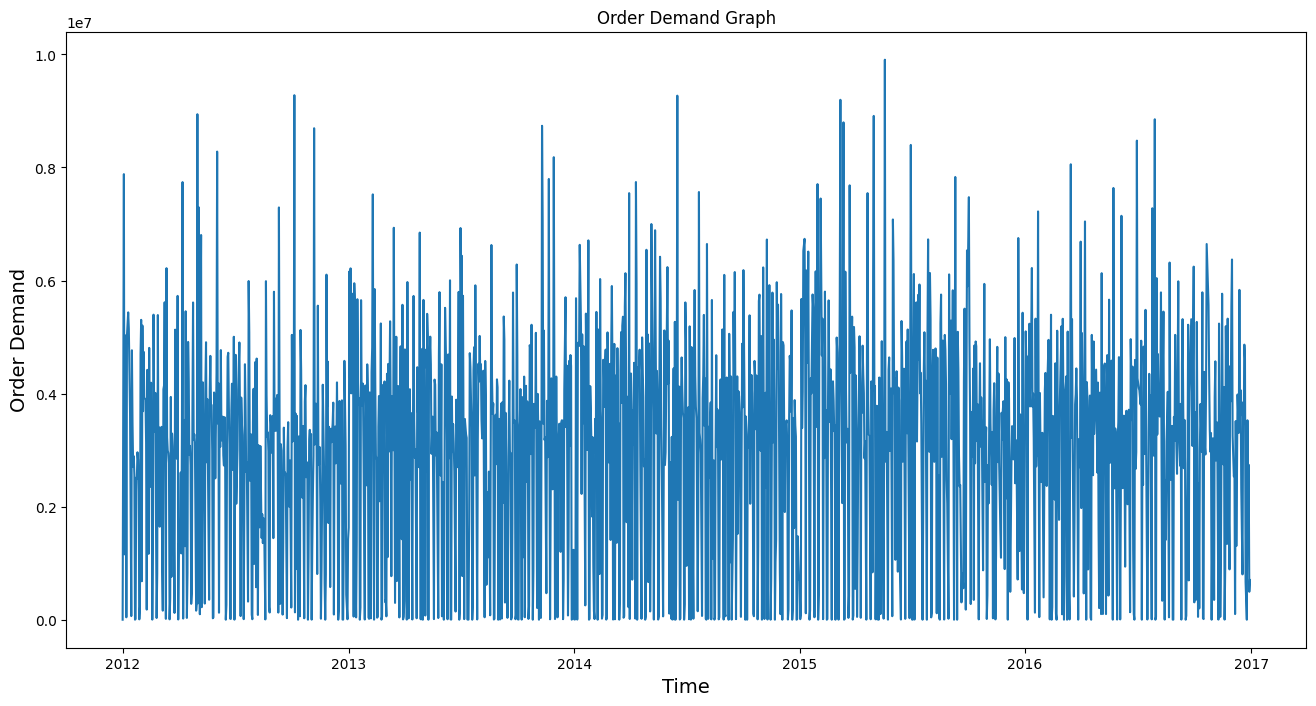

In [32]:
# Visualize the order demand as time series
plt.figure(figsize=(16, 8))
plt.title("Order Demand Graph")
plt.plot(df["Date"], df["OrderDemand"])
plt.xlabel("Time", fontsize=14,)
plt.ylabel("Order Demand", fontsize=14)
plt.show()

In [33]:
# Create new data with only the "OrderDemand" column
orderD = df.filter(["OrderDemand"])
# Convert the dataframe to a np array
orderD_array = orderD.values
# See the train data len
train_close_len = math.ceil(len(orderD_array) * 0.8)
train_close_len

1345

In [34]:
# Normalize the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(orderD_array)
scaled_data

array([[4.05800279e-05],
       [3.71685598e-01],
       [7.95656342e-01],
       ...,
       [2.76634656e-01],
       [4.99191882e-02],
       [7.09999070e-02]])

In [35]:
# Create the training dataset
train_data = scaled_data[0 : train_close_len, :]
# Create X_train and y_train
X_train = []
y_train = []
for i in range(60, len(train_data)):
    X_train.append(train_data[i - 60 : i, 0])
    y_train.append(train_data[i, 0])
    if i <= 60:
        print(X_train)
        print(y_train)

[array([4.05800279e-05, 3.71685598e-01, 7.95656342e-01, 1.16739352e-01,
       4.26453292e-01, 5.07641613e-01, 4.31299073e-03, 5.07594270e-01,
       5.48837912e-01, 5.20259983e-01, 3.67992311e-01, 6.52611643e-03,
       4.81139624e-01, 3.49484184e-01, 2.73182123e-01, 2.92016909e-01,
       2.58590575e-01, 6.05672058e-05, 1.40929793e-03, 2.53712795e-01,
       2.51402661e-01, 2.99000106e-01, 2.85484433e-01, 2.29704560e-01,
       6.66239264e-04, 2.36699669e-02, 4.74813077e-01, 5.35489405e-01,
       6.87111733e-02, 5.25320373e-01, 3.72336494e-01, 4.78353634e-01,
       3.96463239e-01, 3.93608807e-01, 3.15278249e-01, 1.81198910e-02,
       4.46228586e-01, 2.88114059e-01, 1.17631204e-01, 4.85407795e-01,
       2.36905799e-01, 3.43446744e-01, 4.23215471e-01, 2.93014653e-01,
       2.11985220e-04, 1.28435889e-01, 5.44729538e-01, 3.65252251e-01,
       3.36275890e-01, 4.05054596e-01, 1.74837738e-01, 3.06873843e-03,
       8.26950307e-02, 5.44036649e-01, 2.48954534e-01, 3.43418278e-01,
     

In [36]:
#  make X_train and y_train np array
X_train, y_train = np.array(X_train), np.array(y_train)

In [37]:
# reshape the data
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train.shape

(1285, 60, 1)

In [38]:
# create the testing dataset
test_data = scaled_data[train_close_len - 60 : , :]
# create X_test and y_test
X_test = []
y_test = df.iloc[train_close_len : , :]
for i in range(60, len(test_data)):
    X_test.append(test_data[i - 60 : i, 0])

In [39]:
# convert the test data to a np array and reshape the test data
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

## Build a LSTM Model

In [40]:
# Build the LSTM Model
model = Sequential()

model.add(LSTM(units=512, return_sequences=True, activation='relu', input_shape=(X_train.shape[1], 1)))


model.add(LSTM(units=256, activation='relu', return_sequences=False))


model.add(Dense(units=1))

In [41]:
# compile the LSTM model
model.compile(optimizer="Adam", loss="mean_squared_error", metrics=['mae'])

In [42]:
# train the LSTM model
model.fit(X_train, y_train,
          epochs=3,
          batch_size=100, 
          verbose=1)

Epoch 1/3
13/13 [==============================] - 64s 3s/step - loss: 0.0758 - mae: 0.2281
Epoch 2/3
13/13 [==============================] - 43s 3s/step - loss: 0.0518 - mae: 0.1879
Epoch 3/3
13/13 [==============================] - 28s 2s/step - loss: 0.0421 - mae: 0.1662


In [43]:
# predict with LSTM model
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

11/11 [==============================] - 5s 321ms/step


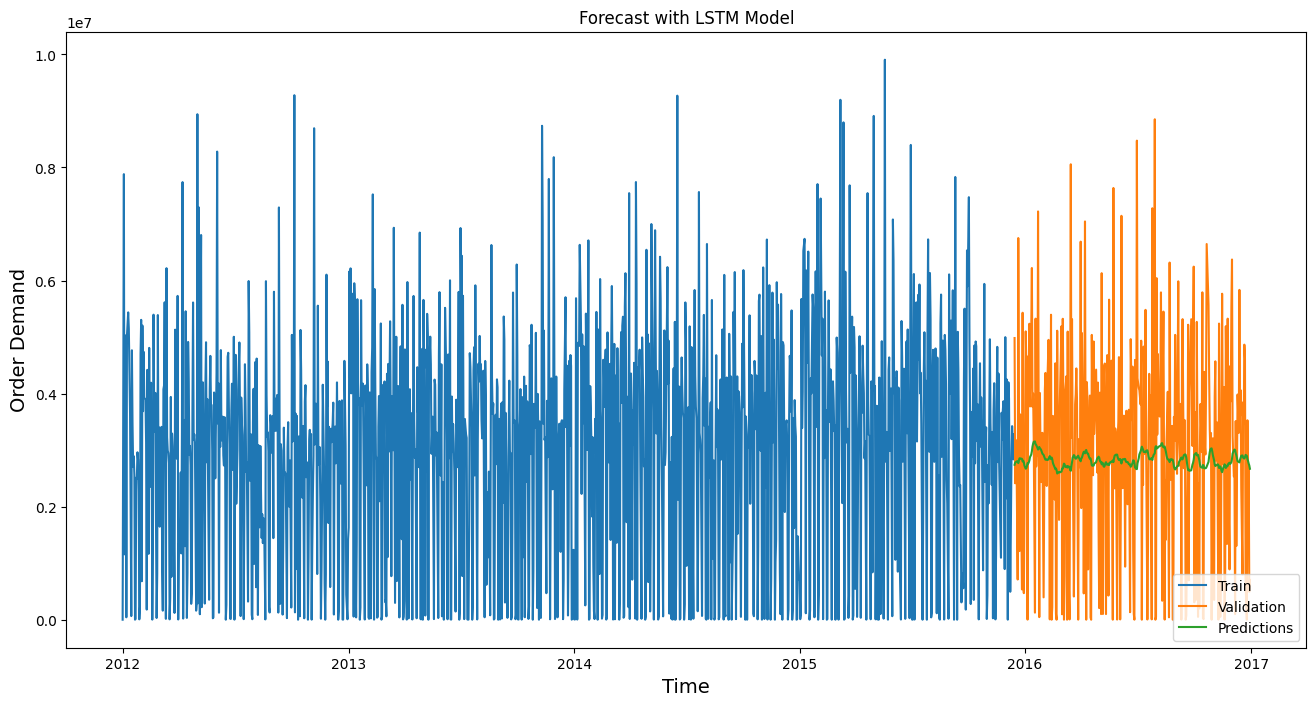

In [44]:
# plot the data
train = orderD[:train_close_len]
valid = orderD[train_close_len:]
valid["Predictions"] = predictions
#visualize the data
plt.figure(figsize=(16, 8))
plt.title("Forecast with LSTM Model")
plt.xlabel("Time", fontsize=14)
plt.ylabel("Order Demand", fontsize=14)
plt.plot(df["Date"][:train_close_len], train["OrderDemand"])
plt.plot(df["Date"][train_close_len:], valid[["OrderDemand", "Predictions"]])
plt.legend(["Train", "Validation", "Predictions"], loc="lower right")
plt.show()

In [46]:
import xgboost as xgb

# Prepare data for XGBoost model
train_dmatrix = xgb.DMatrix(data=X_train, label=y_train)
test_dmatrix = xgb.DMatrix(data=X_test)

# Train XGBoost model
xgb_model = xgb.XGBRegressor(n_estimators=1000, learning_rate=0.05)
xgb_model.fit(X_train, y_train, early_stopping_rounds=10, eval_set=[(X_test, y_test)], verbose=1)

# Predict with XGBoost model
xgb_predictions = xgb_model.predict(X_test)
xgb_predictions = scaler.inverse_transform(xgb_predictions.reshape(-1, 1))

# Plot the data
train = orderD[:train_close_len]
valid = orderD[train_close_len:]
valid["Predictions"] = xgb_predictions
plt.figure(figsize=(16, 8))
plt.title("Forecast with XGBoost Model")
plt.xlabel("Time", fontsize=14)
plt.ylabel("Order Demand", fontsize=14)
plt.plot(df["Date"][:train_close_len], train["OrderDemand"])
plt.plot(df["Date"][train_close_len:], valid[["OrderDemand", "Predictions"]])
plt.legend(["Train", "Validation", "Predictions"], loc="lower right")
plt.show()


ValueError: Please reshape the input data into 2-dimensional matrix.

## Build a Optimized LSTM Model

In [ ]:
# change the parameters of first LSTM model and build the Optimized LSTM Model
optimized_model = Sequential()

optimized_model.add(LSTM(512, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], 1)))

optimized_model.add(LSTM(256, activation='relu', return_sequences=False))

optimized_model.add(Dense(128))

optimized_model.add(Dense(64))

optimized_model.add(Dense(32))

optimized_model.add(Dense(1))

In [ ]:
# compile the model
optimized_model.compile(optimizer="Adam", loss="mean_squared_error", metrics=['mae'])

In [ ]:
# train the optimized model
history=optimized_model.fit(X_train, y_train, 
          batch_size=32, 
          epochs=3, 
          verbose=1)

Epoch 1/20
41/41 [==============================] - 49s 1s/step - loss: 0.0422 - mae: 0.1660
Epoch 2/20
41/41 [==============================] - 49s 1s/step - loss: 0.0414 - mae: 0.1634
Epoch 3/20
41/41 [==============================] - 65s 2s/step - loss: 0.0403 - mae: 0.1614
Epoch 4/20
41/41 [==============================] - 71s 2s/step - loss: 0.0409 - mae: 0.1649
Epoch 5/20
41/41 [==============================] - 52s 1s/step - loss: 0.0399 - mae: 0.1611
Epoch 6/20
41/41 [==============================] - 52s 1s/step - loss: 0.0407 - mae: 0.1637
Epoch 7/20
41/41 [==============================] - 46s 1s/step - loss: 0.0406 - mae: 0.1645
Epoch 8/20
41/41 [==============================] - 47s 1s/step - loss: 0.0396 - mae: 0.1603
Epoch 9/20
 8/41 [====>.........................] - ETA: 36s - loss: 0.0368 - mae: 0.1602

In [ ]:
plt.plot(history.history['loss'])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel('epoch')
plt.show()

In [ ]:
plt.plot(history.history['mae'])
plt.title("model performance metric")
plt.ylabel("mae")
plt.xlabel('epoch')
plt.show()

In [ ]:
# Predict with optimized LSTM model
o_predictions = optimized_model.predict(X_test)
o_predictions = scaler.inverse_transform(o_predictions)

In [ ]:
# plot the data
train = orderD[:train_close_len]
valid = orderD[train_close_len:]
valid["Predictions"] = o_predictions
#visualize the data
plt.figure(figsize=(16, 8))
plt.title("Forecast with Optimized LSTM Model")
plt.xlabel("Time", fontsize=14)
plt.ylabel("Order Demand", fontsize=14)
plt.plot(df["Date"][:train_close_len], train["OrderDemand"])
plt.plot(df["Date"][train_close_len:], valid[["OrderDemand", "Predictions"]])
plt.legend(["Train", "Validation", "Predictions"], loc="upper right")
plt.show()

This is a simple LSTM model you can change the hyperparameter and achieve better results.